In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.CIFAR10(root='../Data/', train=True, download=True, transform=transform)

100.0%


Extracting ../Data/cifar-10-python.tar.gz to ../Data/


In [4]:
test_data = datasets.CIFAR10(root='../Data/', train=False, download=True, transform=transform)

Files already downloaded and verified


In [5]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../Data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../Data/
    Split: Test
    StandardTransform
Transform: ToTensor()

In [8]:
torch.manual_seed(101)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [9]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

In [10]:
for images, labels in train_loader:
    break

In [11]:
labels

tensor([1, 5, 8, 1, 6, 1, 6, 3, 7, 9])

Label: [1 5 8 1 6 1 6 3 7 9]
Class:    car   dog  ship   car  frog   car  frog   cat horse truck


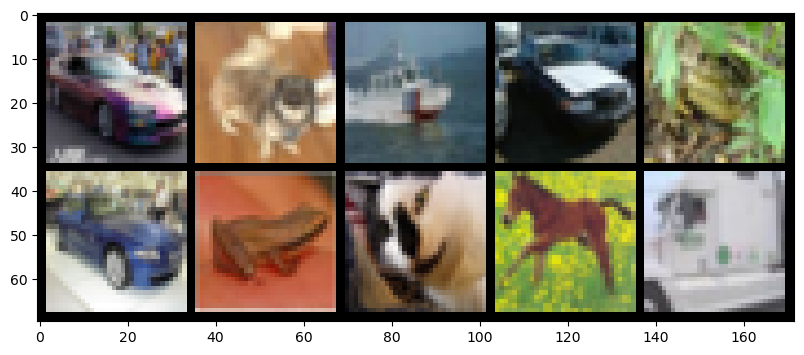

In [13]:
# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)
plt.figure(figsize=(10, 4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

# The model follows CONV/RELU/POOL/CONV/RELU/POOL/FC/RELU/FC

In [17]:
# how to get 6*6*16 for self.fc1
images[0].shape

torch.Size([3, 32, 32])

In [18]:
(((32-2)/2)-2)/2

6.5

In [34]:
class ConvolutionalNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, 1)  # 3 channels, 6 filters, ..
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(6*6*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [35]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [36]:
for param in model.parameters():
    print(param.numel())
print(f'total number of parameters: {450+6+864+16+69120+120+10080+84+840+10}')

450
6
864
16
69120
120
10080
84
840
10
total number of parameters: 81590


In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [39]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    train_corr = 0
    test_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        train_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {train_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(train_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            test_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(test_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.33869243  accuracy:  39.390%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.44050622  accuracy:  40.960%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.55919623  accuracy:  42.290%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.95094049  accuracy:  43.365%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 1.20045221  accuracy:  44.352%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.29621959  accuracy:  50.560%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.63740313  accuracy:  50.860%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.29151213  accuracy:  51.000%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 1.04956591  accuracy:  51.322%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 1.25680494  accuracy:  51.936%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.43978035  accuracy:  55.030%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 0.92399442  accuracy:  55.300%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 1.08656263  accuracy:  55.547%
epoch:  2  b

In [40]:
torch.save(model.state_dict(), 'myCIFARmodel_sm.pt')

In [42]:
train_losses = [loss.item() for loss in train_losses]
test_losses = [loss.item() for loss in test_losses]

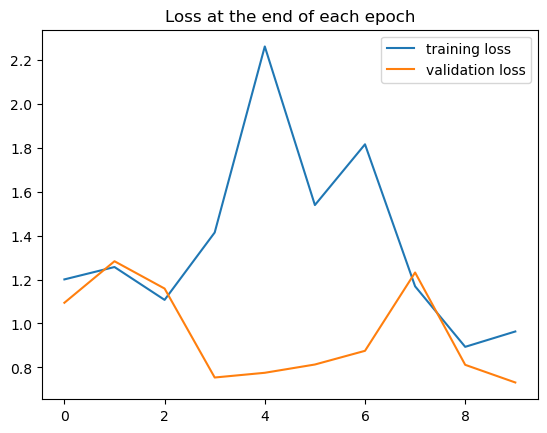

In [43]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

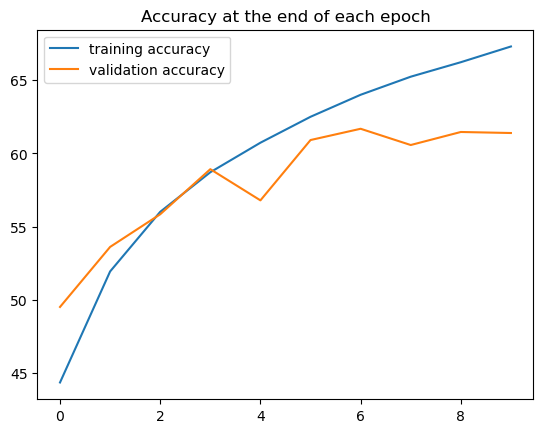

In [44]:
plt.plot([t/500 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [45]:
print(test_correct)

[tensor(4951), tensor(5361), tensor(5584), tensor(5892), tensor(5679), tensor(6091), tensor(6168), tensor(6057), tensor(6146), tensor(6139)]


In [47]:
num_c = test_correct[-1].item()

In [48]:
num_c *100/10000

61.39

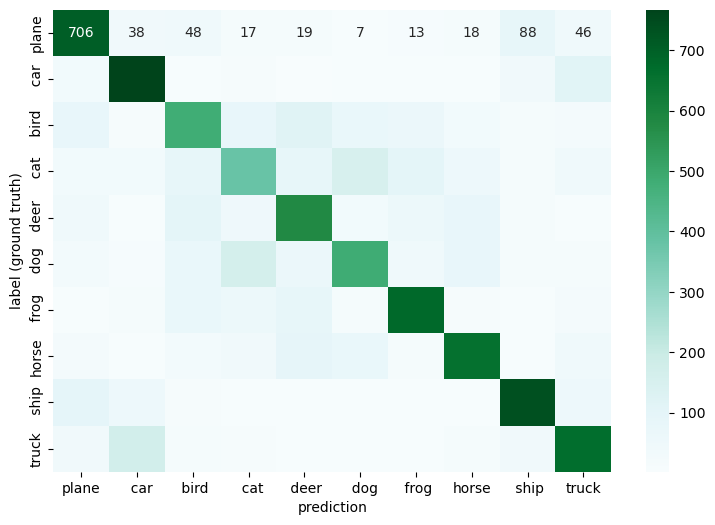

In [49]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();